In [1]:
import pandas as pd

# 사용자 데이터 로드
users_df = pd.read_csv("/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/train_users_2.csv")

# 나이 필터링
users_df = users_df[(users_df['age'] >= 18) & (users_df['age'] <= 122)]

# 성별 필터링
users_df['gender'] = users_df['gender'].replace({'-unknown-': 'ufs'})

# 'id' 열 이름을 'user_id'로 변경
users_df.rename(columns={'id': 'user_id'}, inplace=True)

# 초기 유입 경로 필터링
users_df['first_affiliate_tracked'] = users_df['first_affiliate_tracked'].fillna('untracked')

# 날짜 데이터를 DateTime 형식으로 변환
users_df['date_account_created'] = pd.to_datetime(users_df['date_account_created'])
users_df['timestamp_first_active'] = pd.to_datetime(users_df['timestamp_first_active'], format='%Y%m%d%H%M%S')

# object 타입을 category로 변환
categorical_columns = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for col in categorical_columns:
    users_df[col] = users_df[col].astype('category')

# 결과 확인
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124522 entries, 1 to 213448
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   user_id                  124522 non-null  object        
 1   date_account_created     124522 non-null  datetime64[ns]
 2   timestamp_first_active   124522 non-null  datetime64[ns]
 3   date_first_booking       68134 non-null   object        
 4   gender                   124522 non-null  category      
 5   age                      124522 non-null  float64       
 6   signup_method            124522 non-null  category      
 7   signup_flow              124522 non-null  category      
 8   language                 124522 non-null  category      
 9   affiliate_channel        124522 non-null  category      
 10  affiliate_provider       124522 non-null  category      
 11  first_affiliate_tracked  124522 non-null  category      
 12  signup_app           

In [2]:

sessions_df = pd.read_csv('/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/sessions.csv')
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [3]:
users_df['booked'] = users_df['date_first_booking'].notnull().astype(int)

In [4]:
users_df

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,booked
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,1
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,1
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,ufs,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,1
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,omlc9iku7t,2014-06-30,2014-06-30 23:51:51,2014-08-13,FEMALE,34.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,ES,1
213443,0k26r3mir0,2014-06-30,2014-06-30 23:53:40,2014-07-13,FEMALE,36.0,basic,0,en,sem-brand,google,linked,Web,Mac Desktop,Safari,US,1
213445,qbxza0xojf,2014-06-30,2014-06-30 23:55:47,2014-07-02,FEMALE,23.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,US,1
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,0


In [5]:
# object 타입을 category로 변환
categorical_columns_sessions = ['action', 'action_type', 'action_detail', 'device_type']
for col in categorical_columns_sessions:
    sessions_df[col] = sessions_df[col].astype('category')

# 결과 확인
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype   
---  ------         -----   
 0   user_id        object  
 1   action         category
 2   action_type    category
 3   action_detail  category
 4   device_type    category
 5   secs_elapsed   float64 
dtypes: category(4), float64(1), object(1)
memory usage: 221.7+ MB


In [6]:

sessions_df = pd.read_csv('/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/sessions.csv')

# action_type 열에서 NaN 값을 갖는 행들을 필터링
nan_action = sessions_df[sessions_df['action'].isna()]

# NaN 값을 갖는 행들 출력
print(nan_action)

# NaN 값의 개수 확인
nan_action_count = sessions_df['action'].isna().sum()
print(f'Number of NaN values in action column: {nan_action_count}')

             user_id action   action_type action_detail      device_type  \
45        d1mm9tcy42    NaN  message_post  message_post  Windows Desktop   
138       4grx6yxeby    NaN  message_post  message_post  Windows Desktop   
317       xwxei6hdk4    NaN  message_post  message_post      iPad Tablet   
320       xwxei6hdk4    NaN  message_post  message_post      iPad Tablet   
382       ro2stddszp    NaN  message_post  message_post      Mac Desktop   
...              ...    ...           ...           ...              ...   
10566820  gpijioh4eh    NaN  message_post  message_post      Mac Desktop   
10566859  gpijioh4eh    NaN  message_post  message_post      Mac Desktop   
10566961  gpijioh4eh    NaN  message_post  message_post      Mac Desktop   
10566984  gpijioh4eh    NaN  message_post  message_post      Mac Desktop   
10567142  kofaz2kh70    NaN  message_post  message_post      Mac Desktop   

          secs_elapsed  
45                 NaN  
138            59801.0  
317         

In [7]:
# 사용자 데이터와 세션 데이터 병합
merged_df = pd.merge(users_df, sessions_df, on='user_id', how='inner')




In [8]:
merged_df.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,booked,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,1,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,1,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,1,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,1,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,1,lookup,NaN,NaN,Windows Desktop,435.0


In [18]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406534 entries, 0 to 3406533
Data columns (total 25 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   user_id                  object         
 1   date_account_created     datetime64[ns] 
 2   timestamp_first_active   datetime64[ns] 
 3   date_first_booking       object         
 4   gender                   category       
 5   age                      float64        
 6   signup_method            category       
 7   signup_flow              category       
 8   language                 category       
 9   affiliate_channel        category       
 10  affiliate_provider       category       
 11  first_affiliate_tracked  category       
 12  signup_app               category       
 13  first_device_type        category       
 14  first_browser            category       
 15  country_destination      object         
 16  booked                   int64          
 17  action  

In [9]:

# 세션 타임스탬프 생성
merged_df['timestamp_first_active'] = pd.to_datetime(merged_df['timestamp_first_active'], format='%Y%m%d%H%M%S')
merged_df['secs_elapsed'] = pd.to_timedelta(merged_df['secs_elapsed'], unit='s')
merged_df['session_timestamp'] = merged_df['timestamp_first_active'] + merged_df['secs_elapsed']

In [19]:
# NaN 값을 0으로 채우기
merged_df['secs_elapsed'] = merged_df['secs_elapsed'].fillna(0)

# secs_elapsed 값이 0인 행 제거
merged_df = merged_df[merged_df['secs_elapsed'] != 0]

# 세션 타임스탬프 생성
merged_df['session_timestamp'] = merged_df['timestamp_first_active'] + pd.to_timedelta(merged_df['secs_elapsed'], unit='s')


In [20]:
merged_df['session_timestamp']

0         2014-01-01 00:14:55
1         2014-01-01 18:58:49
2         2014-01-01 00:14:37
3         2014-01-01 06:18:37
4         2014-01-01 00:16:51
                  ...        
3406528   2014-07-01 02:35:25
3406529   2014-07-01 00:02:40
3406530   2014-07-01 01:42:11
3406532   2014-06-30 23:58:44
3406533   2014-07-01 00:21:06
Name: session_timestamp, Length: 3365151, dtype: datetime64[ns]

In [21]:
# 예약 여부를 고려한 DAU 계산
merged_df['date'] = merged_df['session_timestamp'].dt.date
dau = merged_df.groupby(['date', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
dau.columns = ['date', 'affiliate_channel', 'device_type', 'booked', 'DAU']

In [22]:
# 예약 전환율 계산
dau_pivot = dau.pivot_table(index=['date', 'affiliate_channel', 'device_type'], columns='booked', values='DAU', fill_value=0).reset_index()
dau_pivot.columns = ['date', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']
dau_pivot['conversion_rate'] = dau_pivot['DAU_booked'] / (dau_pivot['DAU_not_booked'] + dau_pivot['DAU_booked'])

# 결과 확인
print(dau_pivot)



             date affiliate_channel                       device_type  \
0      2014-01-01               api                         -unknown-   
1      2014-01-01               api  Android App Unknown Phone/Tablet   
2      2014-01-01               api                     Android Phone   
3      2014-01-01               api                        Blackberry   
4      2014-01-01               api                        Chromebook   
...           ...               ...                               ...   
22619  2014-07-21               seo                   Windows Desktop   
22620  2014-07-21               seo                     Windows Phone   
22621  2014-07-21               seo                       iPad Tablet   
22622  2014-07-21               seo                            iPhone   
22623  2014-07-21               seo                         iPodtouch   

       DAU_not_booked  DAU_booked  conversion_rate  
0                   9           3             0.25  
1                

In [23]:
# 예약 전환율이 가장 높은 상위 10개의 카테고리 그룹 선택
top_conversion_rates = dau_pivot.sort_values(by='conversion_rate', ascending=False).head(10)

# 결과 출력
print(top_conversion_rates)


             date affiliate_channel                       device_type  \
6456   2014-02-27         sem-brand                     Android Phone   
18239  2014-06-12     sem-non-brand                       iPad Tablet   
18276  2014-06-13           content                       Mac Desktop   
3316   2014-01-30       remarketing                            iPhone   
3313   2014-01-30       remarketing                   Windows Desktop   
6455   2014-02-27         sem-brand  Android App Unknown Phone/Tablet   
5560   2014-02-19         sem-brand                     Android Phone   
18253  2014-06-12               seo                       iPad Tablet   
11568  2014-04-14            direct                        Chromebook   
11577  2014-04-14            direct                         iPodtouch   

       DAU_not_booked  DAU_booked  conversion_rate  
6456                0           2              1.0  
18239               0           3              1.0  
18276               0           2    

통계수가 적어 다 1.0이 나옴

In [35]:
# 주 단위로 변환
merged_df['week'] = merged_df['session_timestamp'].dt.to_period('W')

# 주간 활성 사용자 (WAU) 계산
wau = merged_df.groupby(['week', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
wau.columns = ['week', 'affiliate_channel', 'device_type', 'booked', 'WAU']

In [36]:
# 예약 전환율 계산
wau_pivot = wau.pivot_table(index=['week', 'affiliate_channel', 'device_type'], columns='booked', values='WAU', fill_value=0).reset_index()
wau_pivot.columns = ['week', 'affiliate_channel', 'device_type', 'WAU_not_booked', 'WAU_booked']
wau_pivot['conversion_rate'] = wau_pivot['WAU_booked'] / (wau_pivot['WAU_not_booked'] + wau_pivot['WAU_booked'])
print(wau_pivot)

                       week affiliate_channel  \
0     2013-12-30/2014-01-05               api   
1     2013-12-30/2014-01-05               api   
2     2013-12-30/2014-01-05               api   
3     2013-12-30/2014-01-05               api   
4     2013-12-30/2014-01-05               api   
...                     ...               ...   
3355  2014-07-21/2014-07-27               seo   
3356  2014-07-21/2014-07-27               seo   
3357  2014-07-21/2014-07-27               seo   
3358  2014-07-21/2014-07-27               seo   
3359  2014-07-21/2014-07-27               seo   

                           device_type  WAU_not_booked  WAU_booked  \
0                            -unknown-              56          34   
1     Android App Unknown Phone/Tablet              11           8   
2                        Android Phone               0           0   
3                           Blackberry               0           0   
4                           Chromebook               0       

In [24]:
# 한 달 단위로 데이터 그룹화
merged_df['month'] = merged_df['session_timestamp'].dt.to_period('M')
dau_monthly = merged_df.groupby(['month', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
dau_monthly.columns = ['month', 'affiliate_channel', 'device_type', 'booked', 'DAU']

# 예약 전환율 계산
dau_pivot_monthly = dau_monthly.pivot_table(index=['month', 'affiliate_channel', 'device_type'], columns='booked', values='DAU', fill_value=0).reset_index()
dau_pivot_monthly.columns = ['month', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']
dau_pivot_monthly['conversion_rate'] = dau_pivot_monthly['DAU_booked'] / (dau_pivot_monthly['DAU_not_booked'] + dau_pivot_monthly['DAU_booked'])

# 상위 10개의 예약 전환율 그룹 선택
top_conversion_rates_monthly = dau_pivot_monthly.sort_values(by='conversion_rate', ascending=False).head(10)

# 결과 출력
print(top_conversion_rates_monthly)


       month affiliate_channel    device_type  DAU_not_booked  DAU_booked  \
616  2014-06       remarketing      -unknown-               0           3   
318  2014-03     sem-non-brand  Windows Phone               0           1   
403  2014-04       remarketing    iPad Tablet               0           2   
400  2014-04       remarketing         Tablet               0           2   
67   2014-01       remarketing    iPad Tablet               0           1   
68   2014-01       remarketing         iPhone               0           3   
386  2014-04             other         Tablet               0           1   
377  2014-04            direct      iPodtouch               0           2   
374  2014-04            direct  Windows Phone               0           2   
338  2014-04               api  Android Phone               0           1   

     conversion_rate  
616              1.0  
318              1.0  
403              1.0  
400              1.0  
67               1.0  
68            

전체 데이터의 경향성을 보는게 좋을 것 같음

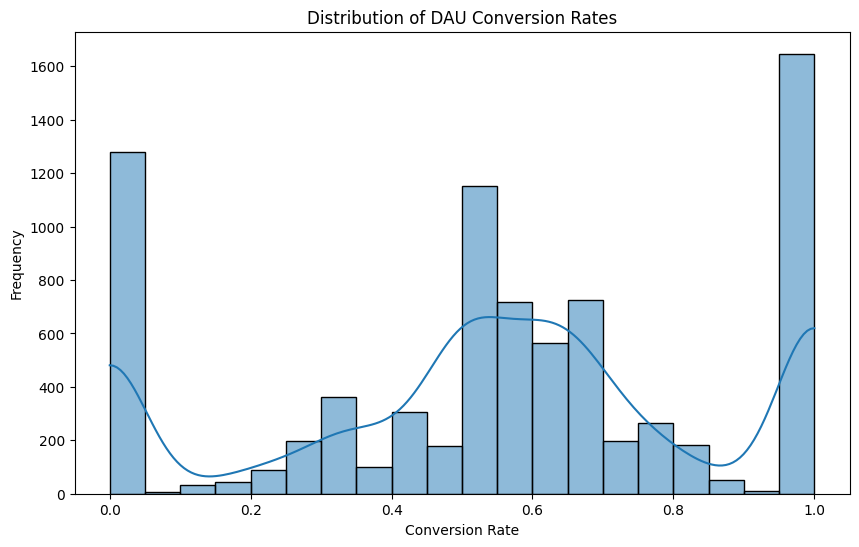

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(dau_pivot['conversion_rate'], bins=20, kde=True)
plt.title('Distribution of DAU Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

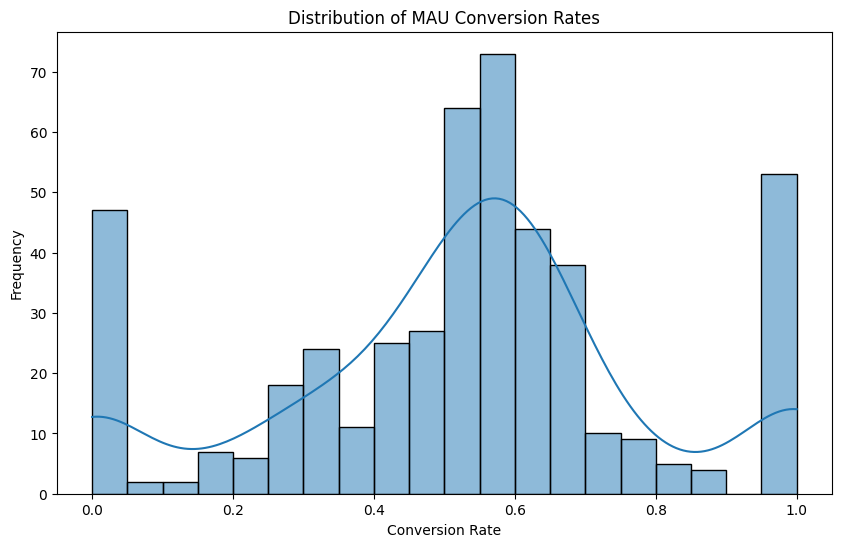

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(dau_pivot_monthly['conversion_rate'], bins=20, kde=True)
plt.title('Distribution of MAU Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

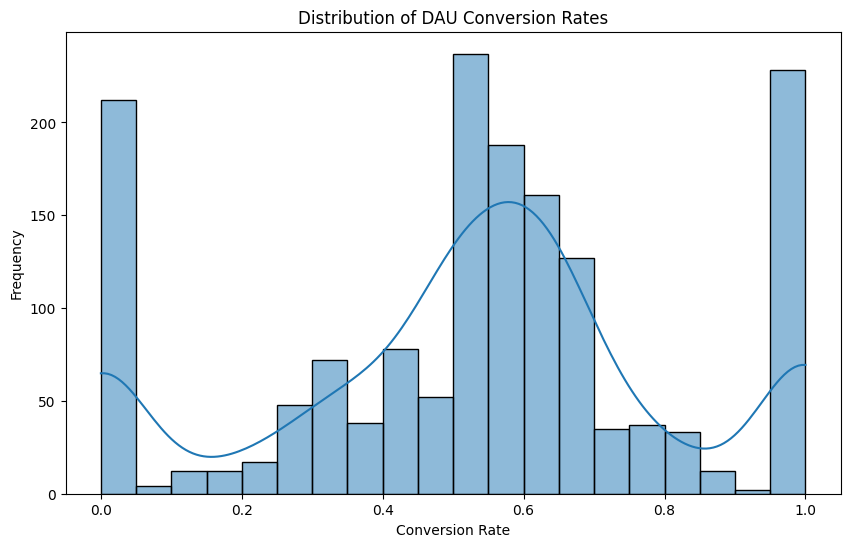

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(wau_pivot['conversion_rate'], bins=20, kde=True)
plt.title('Distribution of DAU Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

예약을 한 유저들 통계


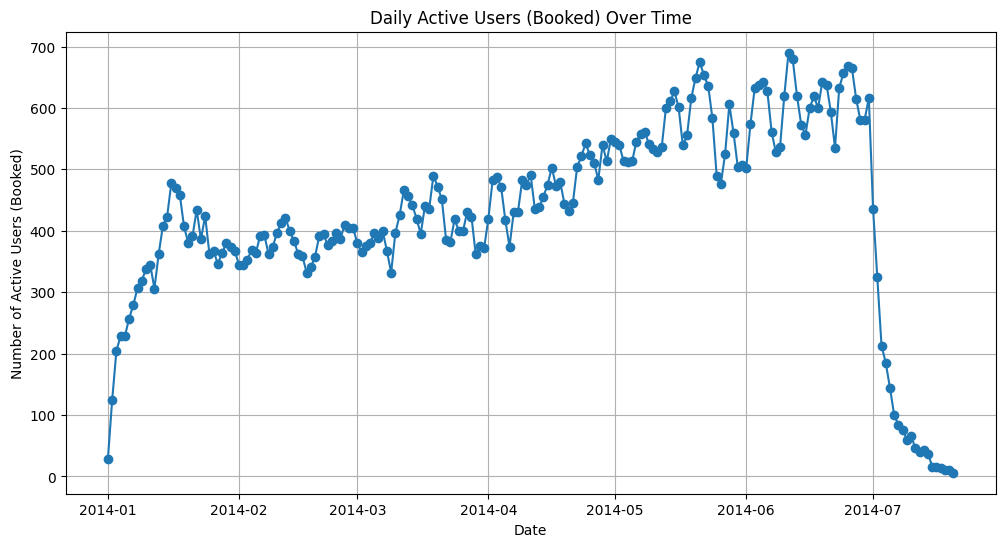

In [33]:
# 예약을 완료한 사용자들 필터링
booked_users_df = merged_df[merged_df['booked'] == 1]

# 일별 예약 완료한 사용자 활동 집계
daily_booked_users = booked_users_df.groupby('date')['user_id'].nunique().reset_index()
daily_booked_users.columns = ['date', 'DAU_booked']

# 시계열 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(daily_booked_users['date'], daily_booked_users['DAU_booked'], marker='o')
plt.title('Daily Active Users (Booked) Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (Booked)')
plt.grid(True)
plt.show()

<ipython-input-34-5fcab690827e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booked_users_df['month'] = booked_users_df['session_timestamp'].dt.to_period('M')


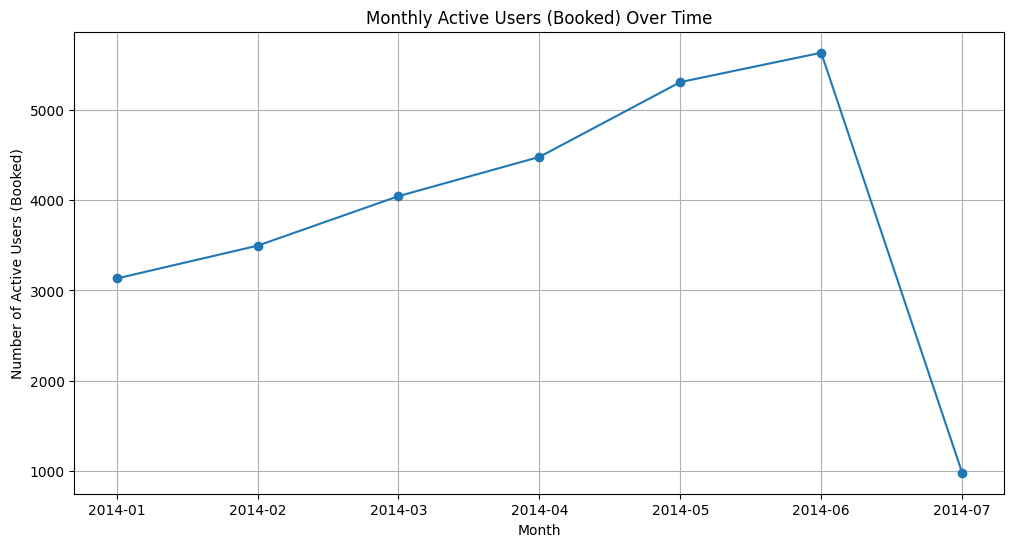

In [34]:
# 예약을 완료한 사용자들 필터링
booked_users_df = merged_df[merged_df['booked'] == 1]

# 월별 예약 완료한 사용자 활동 집계
booked_users_df['month'] = booked_users_df['session_timestamp'].dt.to_period('M')
monthly_booked_users = booked_users_df.groupby('month')['user_id'].nunique().reset_index()
monthly_booked_users.columns = ['month', 'MAU_booked']

# 시계열 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(monthly_booked_users['month'].astype(str), monthly_booked_users['MAU_booked'], marker='o')
plt.title('Monthly Active Users (Booked) Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Active Users (Booked)')
plt.grid(True)
plt.show()

<ipython-input-39-9b63a97cf891>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booked_users_df['week'] = booked_users_df['session_timestamp'].dt.to_period('W')


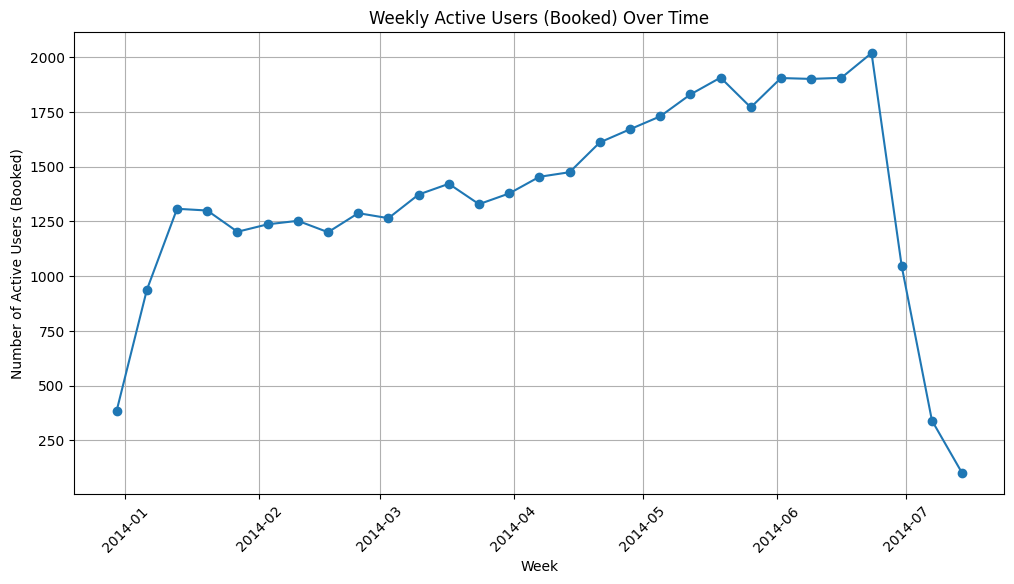

In [39]:
import matplotlib.dates as mdates

# 예약을 완료한 사용자들 필터링
booked_users_df = merged_df[merged_df['booked'] == 1]

# 주 단위로 변환
booked_users_df['week'] = booked_users_df['session_timestamp'].dt.to_period('W')

# 주간 예약 완료한 사용자 활동 집계
weekly_booked_users = booked_users_df.groupby('week')['user_id'].nunique().reset_index()
weekly_booked_users.columns = ['week', 'WAU_booked']

# week 컬럼을 datetime 형식으로 변환
weekly_booked_users['week'] = weekly_booked_users['week'].apply(lambda x: x.start_time)

# 시계열 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(weekly_booked_users['week'], weekly_booked_users['WAU_booked'], marker='o')
plt.title('Weekly Active Users (Booked) Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Active Users (Booked)')
plt.grid(True)

# x축 레이블 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

세션 시간에 따른 예약 전환율

In [40]:
# 세션 타임스탬프에서 시간 정보 추출
merged_df['hour'] = merged_df['session_timestamp'].dt.hour


In [41]:
# 시간대별 예약 완료한 사용자와 총 사용자 수 집계
hourly_users = merged_df.groupby(['hour', 'booked'])['user_id'].nunique().reset_index()
hourly_users.columns = ['hour', 'booked', 'user_count']

# 피벗 테이블 생성
hourly_pivot = hourly_users.pivot_table(index='hour', columns='booked', values='user_count', fill_value=0).reset_index()
hourly_pivot.columns = ['hour', 'not_booked', 'booked']

# 예약 전환율 계산
hourly_pivot['conversion_rate'] = hourly_pivot['booked'] / (hourly_pivot['booked'] + hourly_pivot['not_booked'])


In [42]:
hourly_pivot

,hour,not_booked,booked,conversion_rate
0,0,8538,11712,0.578370
1,1,8680,11781,0.575778
2,2,8693,11828,0.576385
3,3,8697,12007,0.579936
4,4,8676,12241,0.585218
5,5,8868,12388,0.582800
6,6,8762,12309,0.584168
7,7,8483,12072,0.587302
8,8,8219,11480,0.582771
9,9,7783,11048,0.586692


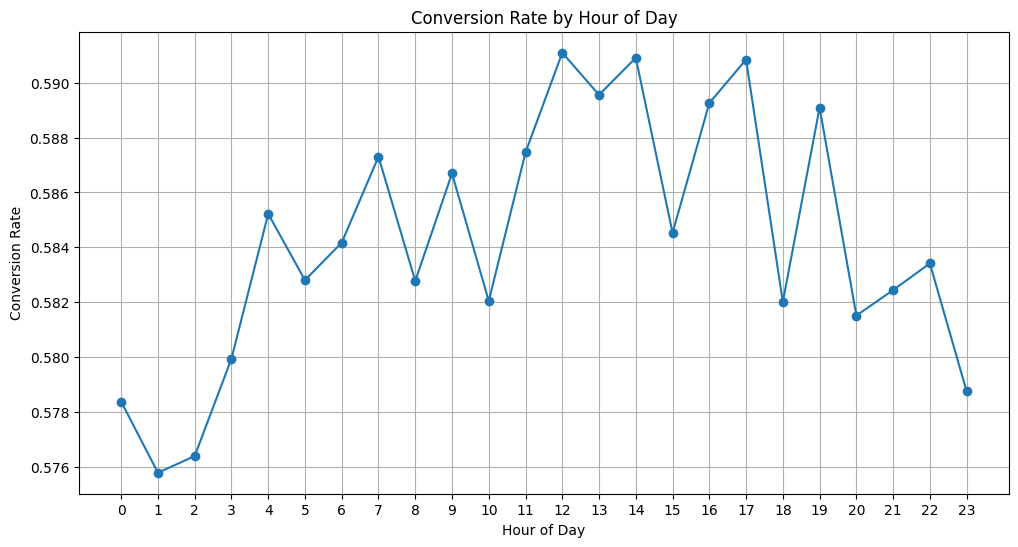

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(hourly_pivot['hour'], hourly_pivot['conversion_rate'], marker='o')
plt.title('Conversion Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

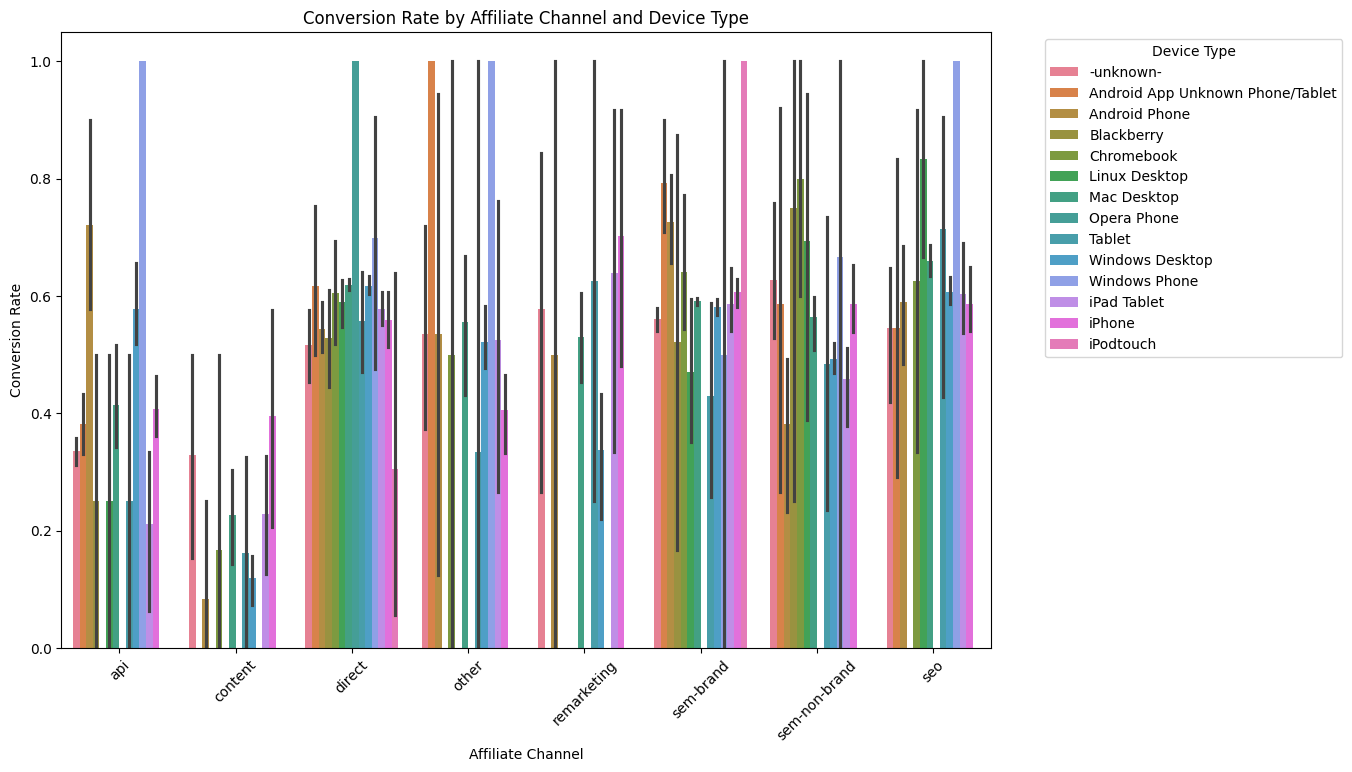

In [16]:
# 카테고리별 전환율 막대 그래프
plt.figure(figsize=(12, 8))
sns.barplot(data=dau_pivot_monthly, x='affiliate_channel', y='conversion_rate', hue='device_type', dodge=True)
plt.title('Conversion Rate by Affiliate Channel and Device Type')
plt.xlabel('Affiliate Channel')
plt.ylabel('Conversion Rate')
plt.legend(title='Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

너무 카테고리가 많아 보기가 어려움.

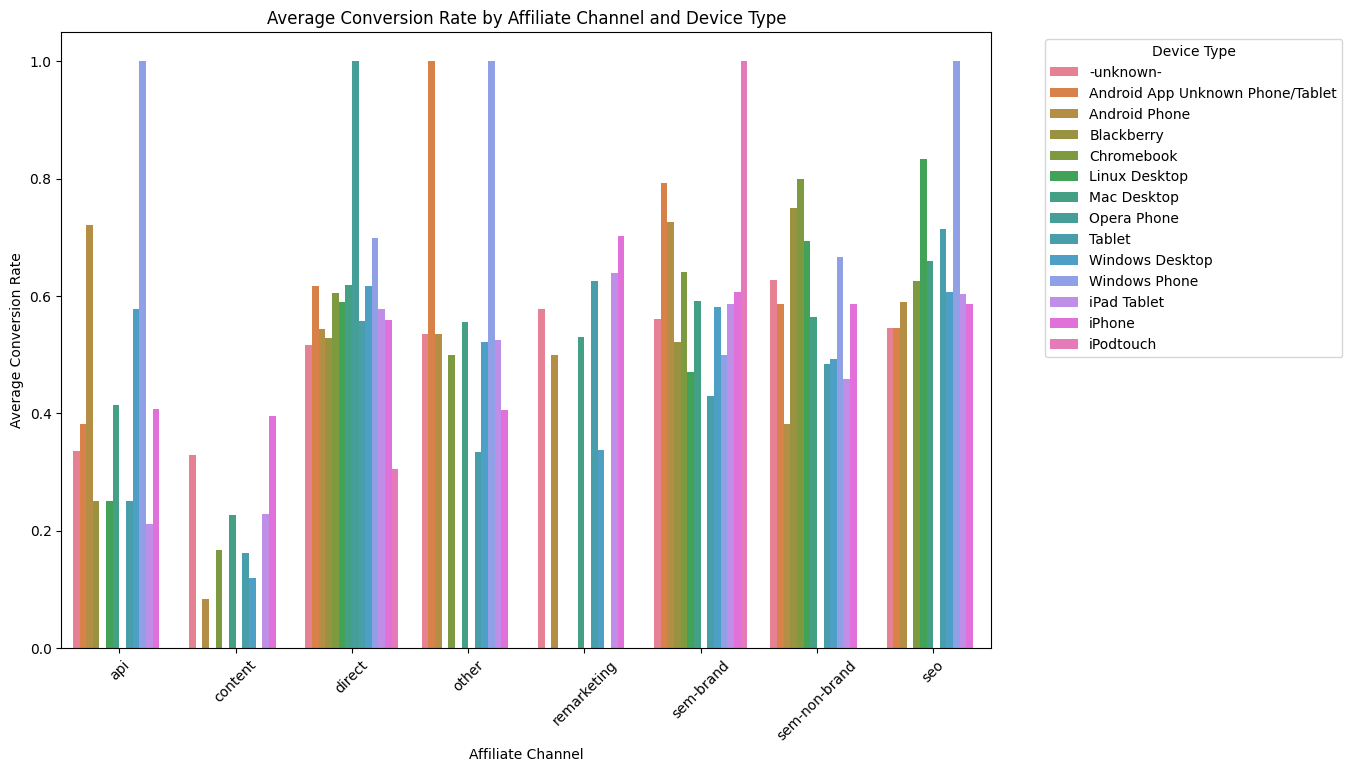

In [17]:
# 카테고리별 평균 전환율 계산
avg_conversion_rates = dau_pivot_monthly.groupby(['affiliate_channel', 'device_type'])['conversion_rate'].mean().reset_index()

# affiliate_channel 별로 평균 전환율 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=avg_conversion_rates, x='affiliate_channel', y='conversion_rate', hue='device_type', dodge=True)
plt.title('Average Conversion Rate by Affiliate Channel and Device Type')
plt.xlabel('Affiliate Channel')
plt.ylabel('Average Conversion Rate')
plt.legend(title='Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

여전히 해석하기 어려움.

따라서 분할된 그래프로 제시

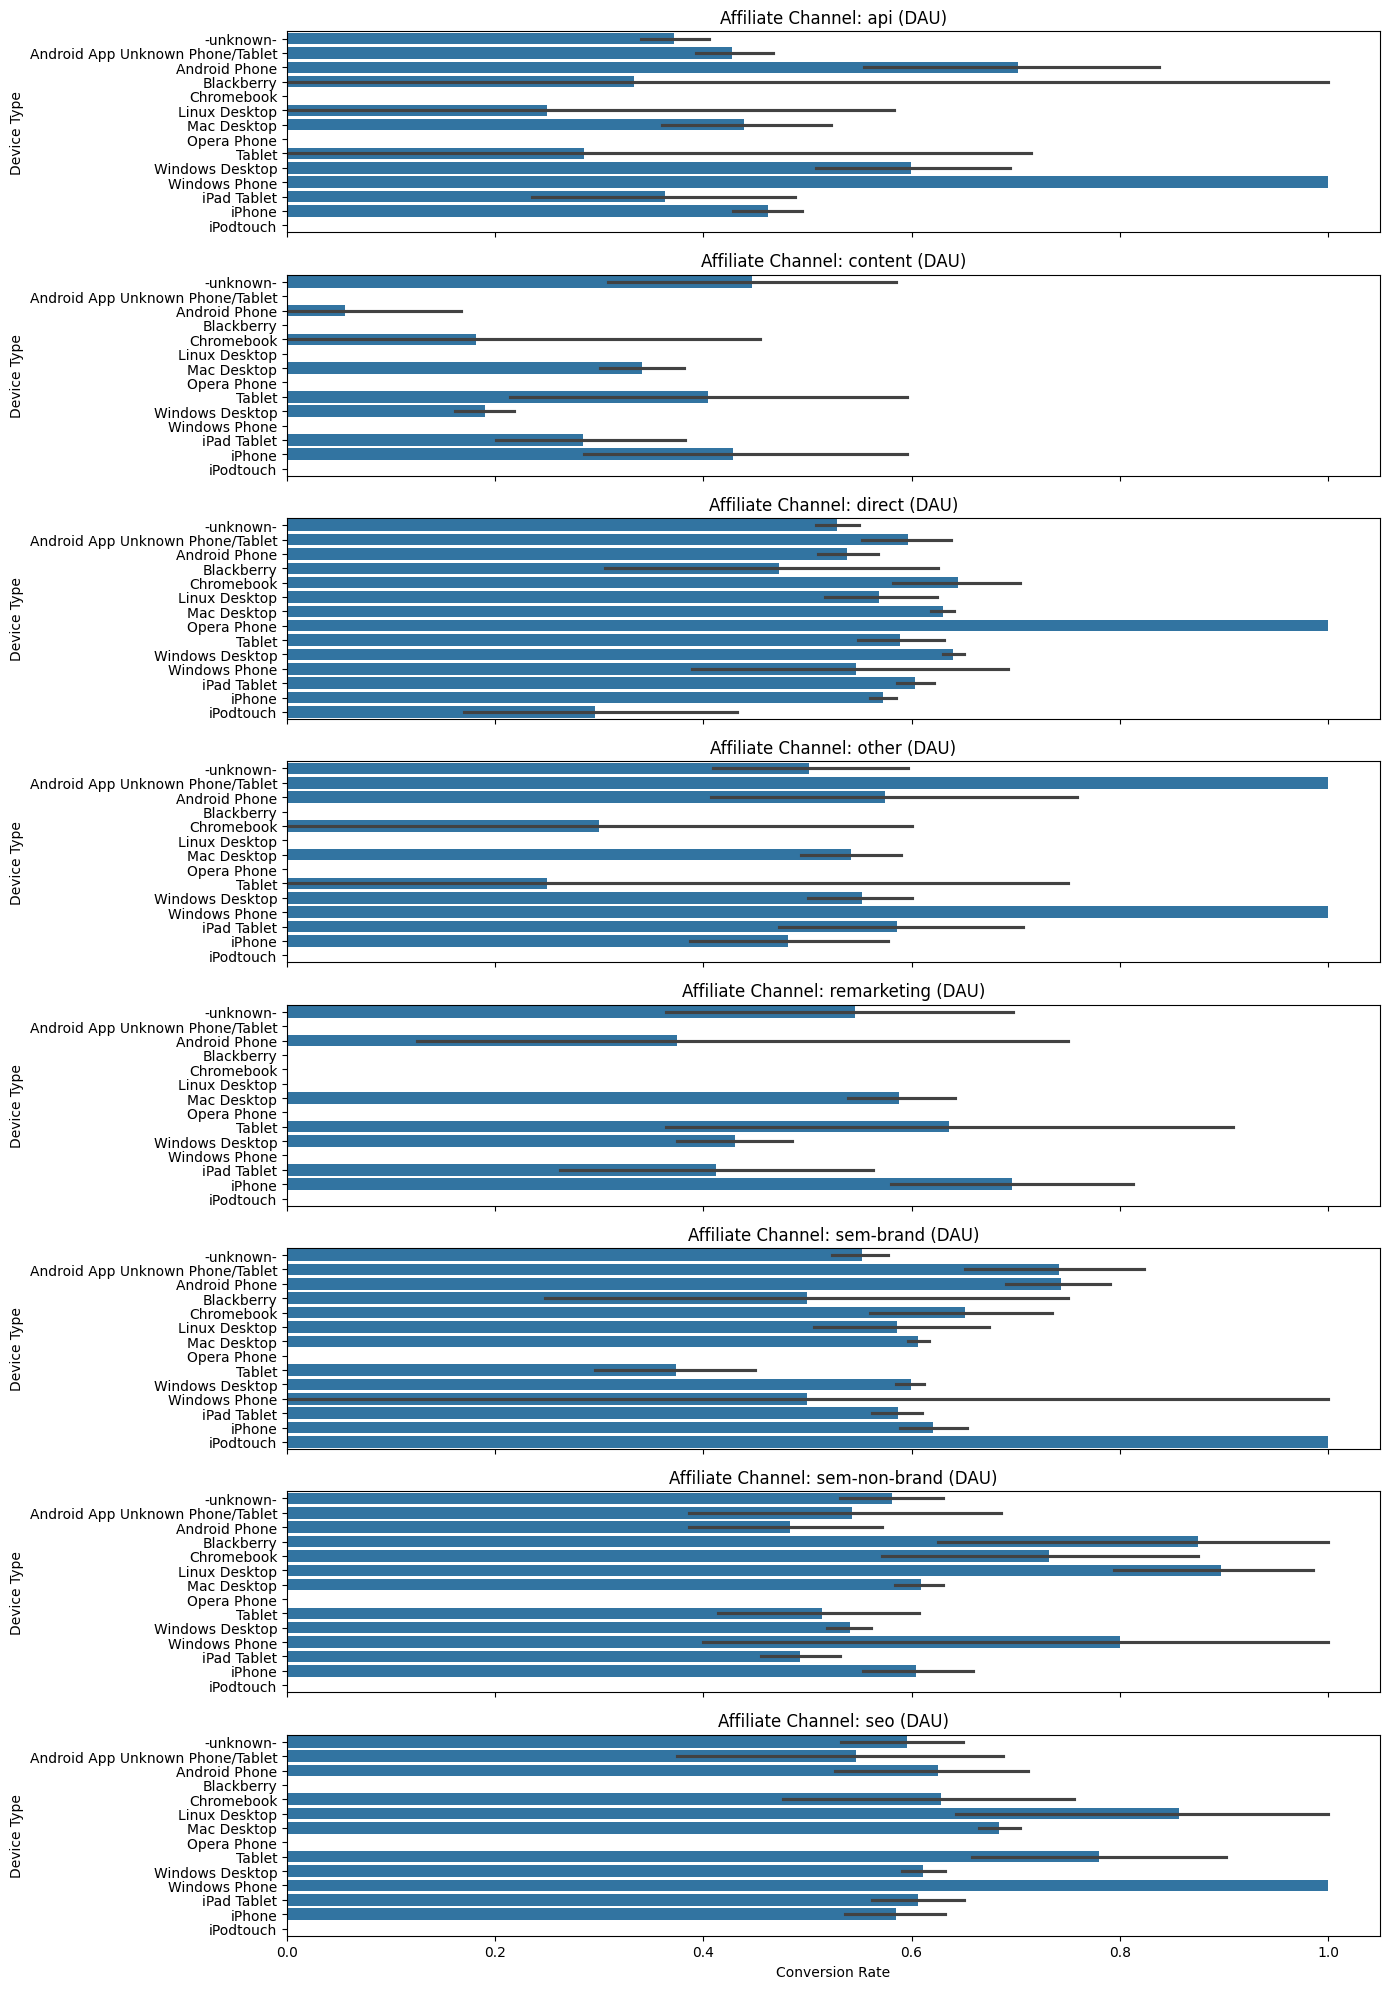

In [ ]:

# DAU 기반 계산
merged_df['date'] = merged_df['session_timestamp'].dt.date
dau = merged_df.groupby(['date', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
dau.columns = ['date', 'affiliate_channel', 'device_type', 'booked', 'DAU']

# 예약 전환율 계산
dau_pivot = dau.pivot_table(index=['date', 'affiliate_channel', 'device_type'], columns='booked', values='DAU', fill_value=0).reset_index()
dau_pivot.columns = ['date', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']
dau_pivot['conversion_rate'] = dau_pivot['DAU_booked'] / (dau_pivot['DAU_not_booked'] + dau_pivot['DAU_booked'])

# affiliate_channel 별로 분할된 그래프
affiliate_channels = dau_pivot['affiliate_channel'].unique()

fig, axes = plt.subplots(nrows=len(affiliate_channels), ncols=1, figsize=(14, 20), sharex=True)

for ax, channel in zip(axes, affiliate_channels):
    sns.barplot(data=dau_pivot[dau_pivot['affiliate_channel'] == channel],
                x='conversion_rate', y='device_type', ax=ax)
    ax.set_title(f'Affiliate Channel: {channel} (DAU)')
    ax.set_xlabel('Conversion Rate')
    ax.set_ylabel('Device Type')

plt.tight_layout()
plt.show()


알기 쉽게 가장 높은 예약 전환율 찾기.

In [ ]:
# 각 카테고리별 최고 전환율을 가진 device type 찾기
max_conversion_rates = avg_conversion_rates.loc[avg_conversion_rates.groupby('affiliate_channel')['conversion_rate'].idxmax()]

# 결과 출력
print(max_conversion_rates[['affiliate_channel', 'device_type', 'conversion_rate']])

    affiliate_channel                       device_type  conversion_rate
10                api                     Windows Phone         1.000000
26            content                            iPhone         0.395238
35             direct                       Opera Phone         1.000000
43              other  Android App Unknown Phone/Tablet         1.000000
68        remarketing                            iPhone         0.702778
83          sem-brand                         iPodtouch         1.000000
88      sem-non-brand                        Chromebook         0.800000
108               seo                     Windows Phone         1.000000


+ 빈도가 높은 곳의 예약 전환율과 카테고리 선별

In [ ]:
import  numpy as np

# NaN 값을 제거
dau_pivot = dau_pivot.dropna(subset=['conversion_rate'])
dau_pivot

,date,affiliate_channel,device_type,DAU_not_booked,DAU_booked,conversion_rate
0,2014-01-01,api,-unknown-,9,3,0.250000
1,2014-01-01,api,Android App Unknown Phone/Tablet,2,2,0.500000
11,2014-01-01,api,iPad Tablet,1,0,0.000000
12,2014-01-01,api,iPhone,1,1,0.500000
28,2014-01-01,direct,-unknown-,4,2,0.333333
...,...,...,...,...,...,...
22476,2014-07-20,sem-brand,Mac Desktop,1,1,0.500000
22479,2014-07-20,sem-brand,Windows Desktop,0,1,1.000000
22482,2014-07-20,sem-brand,iPhone,1,1,0.500000
22504,2014-07-20,seo,Mac Desktop,0,1,1.000000


In [ ]:
# 전환율 히스토그램에서 가장 빈도가 높은 구간 찾기

hist, bin_edges = np.histogram(dau_pivot['conversion_rate'], bins=20)
max_bin_index = np.argmax(hist)
max_bin_start = bin_edges[max_bin_index]
max_bin_end = bin_edges[max_bin_index + 1]

In [ ]:
# 가장 빈도가 높은 구간에 속하는 전환율 필터링
most_frequent_conversion_rates = dau_pivot[(dau_pivot['conversion_rate'] >= max_bin_start) & (dau_pivot['conversion_rate'] < max_bin_end)]

In [ ]:
# 해당 구간에 속하는 device type과 affiliate channel 출력
most_frequent_groups = most_frequent_conversion_rates.groupby(['affiliate_channel', 'device_type']).size().reset_index(name='count')
most_frequent_groups = most_frequent_groups.sort_values(by='count', ascending=False)

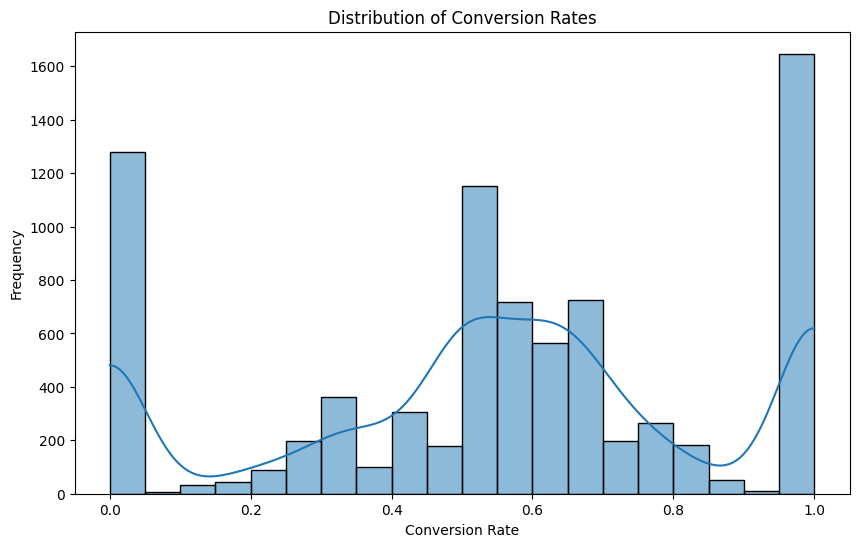

Most frequent bin range: 0.9500000000000001 - 1.0
Empty DataFrame
Columns: [date, affiliate_channel, device_type, DAU_not_booked, DAU_booked, conversion_rate]
Index: []
    affiliate_channel                       device_type  count
0                 api                         -unknown-      0
1                 api  Android App Unknown Phone/Tablet      0
82          sem-brand                            iPhone      0
81          sem-brand                       iPad Tablet      0
80          sem-brand                     Windows Phone      0
..                ...                               ...    ...
33             direct                     Linux Desktop      0
32             direct                        Chromebook      0
31             direct                        Blackberry      0
30             direct                     Android Phone      0
111               seo                         iPodtouch      0

[112 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 전환율 분포 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(dau_pivot['conversion_rate'], bins=20, kde=True)
plt.title('Distribution of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

# 전환율 히스토그램에서 가장 빈도가 높은 구간 찾기
hist, bin_edges = np.histogram(dau_pivot['conversion_rate'], bins=20)
max_bin_index = np.argmax(hist)
max_bin_start = bin_edges[max_bin_index]
max_bin_end = bin_edges[max_bin_index + 1]

print(f'Most frequent bin range: {max_bin_start} - {max_bin_end}')

# 가장 빈도가 높은 구간에 속하는 전환율 필터링
most_frequent_conversion_rates = dau_pivot[(dau_pivot['conversion_rate'] >= max_bin_start) & (dau_pivot['conversion_rate'] < max_bin_end)]

# 필터링된 데이터 확인
print(most_frequent_conversion_rates)

# 해당 구간에 속하는 device type과 affiliate channel 출력
most_frequent_groups = most_frequent_conversion_rates.groupby(['affiliate_channel', 'device_type']).size().reset_index(name='count')
most_frequent_groups = most_frequent_groups.sort_values(by='count', ascending=False)

# 결과 출력
print(most_frequent_groups)


wau,mau도 동일하게 진행

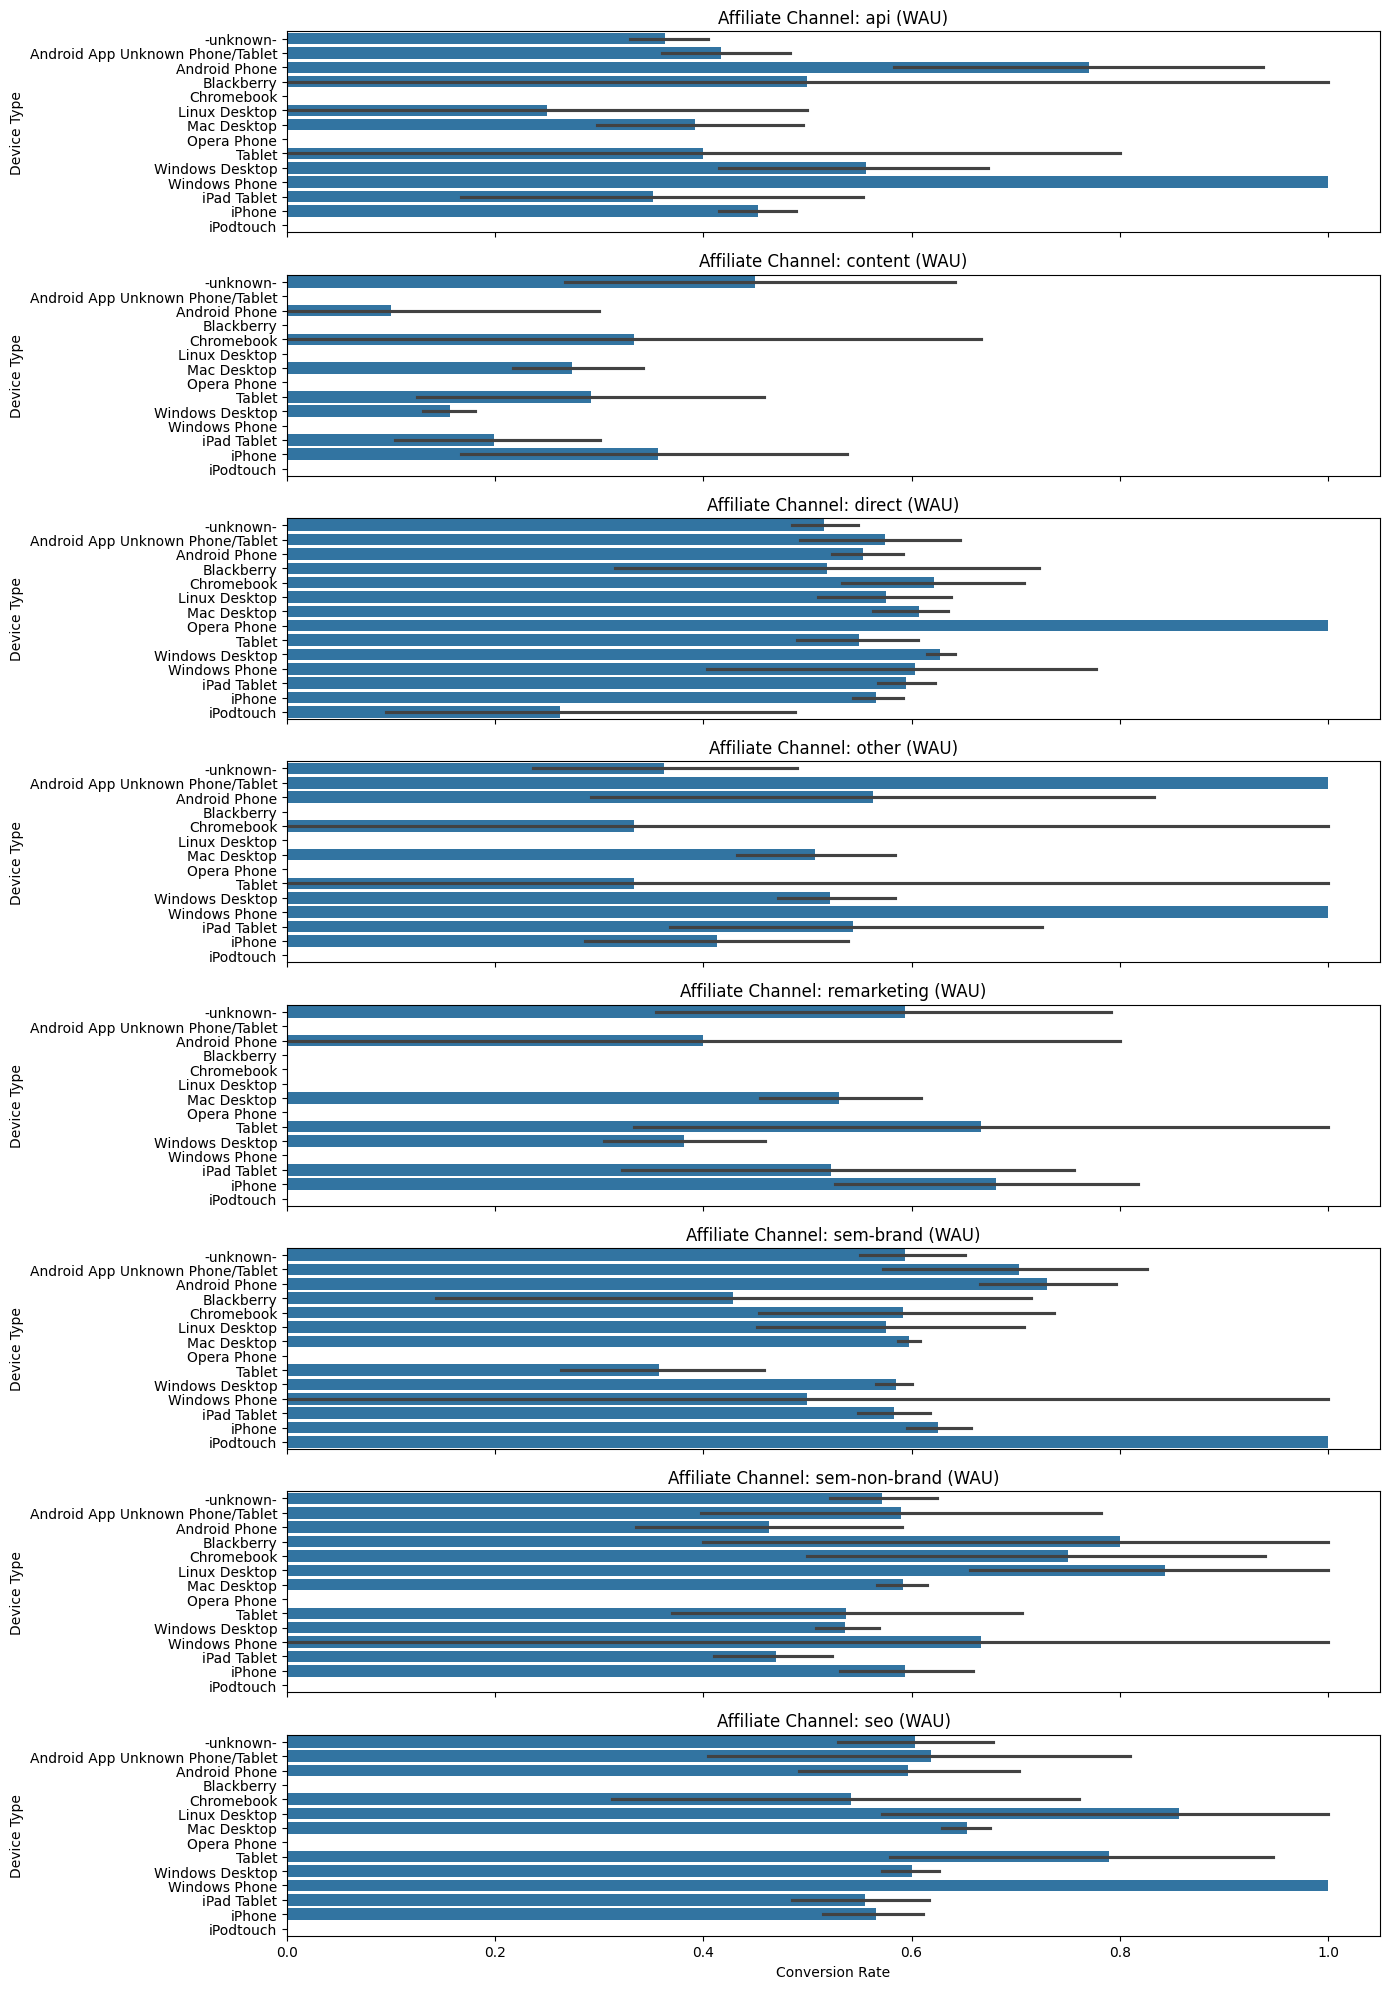

In [ ]:
# 주 단위로 데이터 그룹화
merged_df['week'] = merged_df['session_timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
wau = merged_df.groupby(['week', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
wau.columns = ['week', 'affiliate_channel', 'device_type', 'booked', 'WAU']

# 예약 전환율 계산
wau_pivot = wau.pivot_table(index=['week', 'affiliate_channel', 'device_type'], columns='booked', values='WAU', fill_value=0).reset_index()
wau_pivot.columns = ['week', 'affiliate_channel', 'device_type', 'WAU_not_booked', 'WAU_booked']
wau_pivot['conversion_rate'] = wau_pivot['WAU_booked'] / (wau_pivot['WAU_not_booked'] + wau_pivot['WAU_booked'])

# affiliate_channel 별로 분할된 그래프
affiliate_channels = wau_pivot['affiliate_channel'].unique()

fig, axes = plt.subplots(nrows=len(affiliate_channels), ncols=1, figsize=(14, 20), sharex=True)

for ax, channel in zip(axes, affiliate_channels):
    sns.barplot(data=wau_pivot[wau_pivot['affiliate_channel'] == channel],
                x='conversion_rate', y='device_type', ax=ax)
    ax.set_title(f'Affiliate Channel: {channel} (WAU)')
    ax.set_xlabel('Conversion Rate')
    ax.set_ylabel('Device Type')

plt.tight_layout()
plt.show()


In [ ]:


# 각 카테고리별 최고 전환율을 가진 device type 찾기
max_conversion_rates_wau = avg_conversion_rates_wau.loc[avg_conversion_rates_wau.groupby('affiliate_channel')['conversion_rate'].idxmax()]

# 결과 출력
print(max_conversion_rates_wau[['affiliate_channel', 'device_type', 'conversion_rate']])

    affiliate_channel                       device_type  conversion_rate
10                api                     Windows Phone         1.000000
14            content                         -unknown-         0.450000
35             direct                       Opera Phone         1.000000
43              other  Android App Unknown Phone/Tablet         1.000000
68        remarketing                            iPhone         0.680952
83          sem-brand                         iPodtouch         1.000000
89      sem-non-brand                     Linux Desktop         0.843750
108               seo                     Windows Phone         1.000000


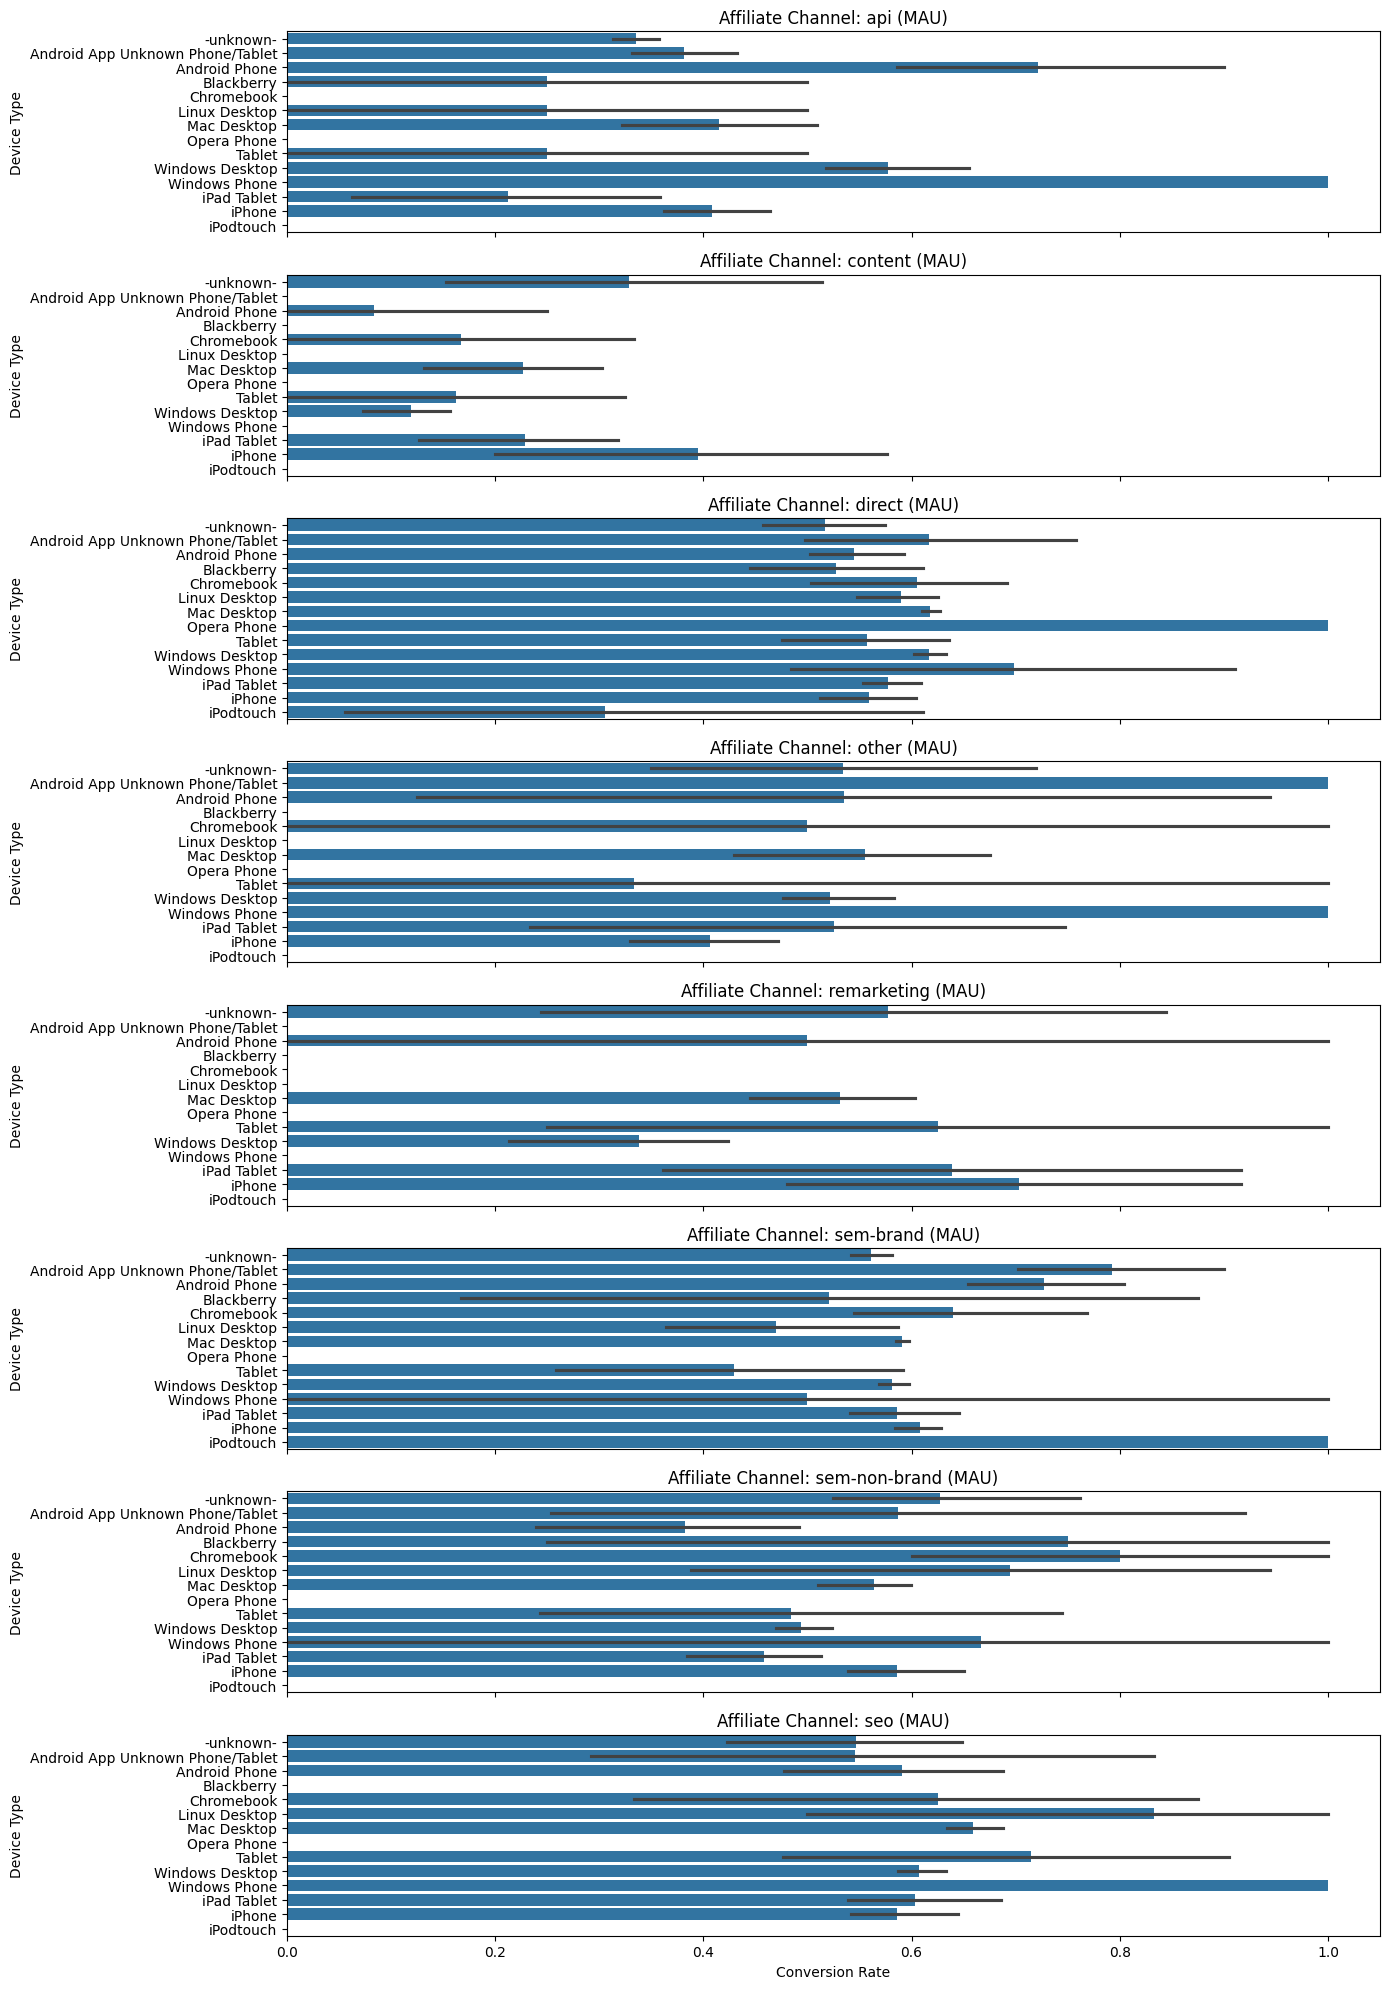

In [ ]:
# 월 단위로 데이터 그룹화
merged_df['month'] = merged_df['session_timestamp'].dt.to_period('M').apply(lambda r: r.start_time)
mau = merged_df.groupby(['month', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
mau.columns = ['month', 'affiliate_channel', 'device_type', 'booked', 'MAU']

# 예약 전환율 계산
mau_pivot = mau.pivot_table(index=['month', 'affiliate_channel', 'device_type'], columns='booked', values='MAU', fill_value=0).reset_index()
mau_pivot.columns = ['month', 'affiliate_channel', 'device_type', 'MAU_not_booked', 'MAU_booked']
mau_pivot['conversion_rate'] = mau_pivot['MAU_booked'] / (mau_pivot['MAU_not_booked'] + mau_pivot['MAU_booked'])

# affiliate_channel 별로 분할된 그래프
affiliate_channels = mau_pivot['affiliate_channel'].unique()

fig, axes = plt.subplots(nrows=len(affiliate_channels), ncols=1, figsize=(14, 20), sharex=True)

for ax, channel in zip(axes, affiliate_channels):
    sns.barplot(data=mau_pivot[mau_pivot['affiliate_channel'] == channel],
                x='conversion_rate', y='device_type', ax=ax)
    ax.set_title(f'Affiliate Channel: {channel} (MAU)')
    ax.set_xlabel('Conversion Rate')
    ax.set_ylabel('Device Type')

plt.tight_layout()
plt.show()


In [ ]:
# 카테고리별 평균 전환율 계산
avg_conversion_rates_mau = mau_pivot.groupby(['affiliate_channel', 'device_type'])['conversion_rate'].mean().reset_index()

# 각 카테고리별 최고 전환율을 가진 device type 찾기
max_conversion_rates_mau = avg_conversion_rates_mau.loc[avg_conversion_rates_mau.groupby('affiliate_channel')['conversion_rate'].idxmax()]
# 최고 전환율 출력
print(max_conversion_rates_mau[['affiliate_channel', 'device_type', 'conversion_rate']])

    affiliate_channel                       device_type  conversion_rate
10                api                     Windows Phone         1.000000
26            content                            iPhone         0.395238
35             direct                       Opera Phone         1.000000
43              other  Android App Unknown Phone/Tablet         1.000000
68        remarketing                            iPhone         0.702778
83          sem-brand                         iPodtouch         1.000000
88      sem-non-brand                        Chromebook         0.800000
108               seo                     Windows Phone         1.000000


In [ ]:
filtered_data

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,action_type,action_detail,device_type,secs_elapsed,session_timestamp,date,month,week,hour,weekday
179020,6z07hqu2dv,2014-01-15,2014-01-15 04:21:50,2014-01-15,FEMALE,30.0,facebook,0,en,other,...,NaN,NaN,Android App Unknown Phone/Tablet,0 days 00:12:04,2014-01-15 04:33:54,2014-01-15,2014-01-01,2014-01-13,4.0,2.0
179021,6z07hqu2dv,2014-01-15,2014-01-15 04:21:50,2014-01-15,FEMALE,30.0,facebook,0,en,other,...,-unknown-,-unknown-,Android App Unknown Phone/Tablet,0 days 00:12:22,2014-01-15 04:34:12,2014-01-15,2014-01-01,2014-01-13,4.0,2.0
179022,6z07hqu2dv,2014-01-15,2014-01-15 04:21:50,2014-01-15,FEMALE,30.0,facebook,0,en,other,...,NaN,NaN,Android App Unknown Phone/Tablet,0 days 07:20:46,2014-01-15 11:42:36,2014-01-15,2014-01-01,2014-01-13,11.0,2.0
179023,6z07hqu2dv,2014-01-15,2014-01-15 04:21:50,2014-01-15,FEMALE,30.0,facebook,0,en,other,...,view,message_inbox,Android App Unknown Phone/Tablet,0 days 00:06:11,2014-01-15 04:28:01,2014-01-15,2014-01-01,2014-01-13,4.0,2.0
179024,6z07hqu2dv,2014-01-15,2014-01-15 04:21:50,2014-01-15,FEMALE,30.0,facebook,0,en,other,...,NaN,NaN,Android App Unknown Phone/Tablet,0 days 00:48:22,2014-01-15 05:10:12,2014-01-15,2014-01-01,2014-01-13,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183707,l0xg3o71lz,2014-03-30,2014-03-30 16:20:11,2014-03-31,FEMALE,28.0,facebook,12,en,api,...,click,confirm_email_link,Windows Phone,0 days 19:18:25,2014-03-31 11:38:36,2014-03-31,2014-03-01,2014-03-31,11.0,0.0
2198753,rs1tl1zv9e,2014-05-15,2014-05-15 18:19:51,2014-05-15,FEMALE,26.0,basic,0,en,sem-brand,...,-unknown-,-unknown-,iPodtouch,2 days 11:55:15,2014-05-18 06:15:06,2014-05-18,2014-05-01,2014-05-12,6.0,6.0
2198754,rs1tl1zv9e,2014-05-15,2014-05-15 18:19:51,2014-05-15,FEMALE,26.0,basic,0,en,sem-brand,...,NaN,NaN,iPodtouch,0 days 00:01:31,2014-05-15 18:21:22,2014-05-15,2014-05-01,2014-05-12,18.0,3.0
2198755,rs1tl1zv9e,2014-05-15,2014-05-15 18:19:51,2014-05-15,FEMALE,26.0,basic,0,en,sem-brand,...,view,user_listings,iPodtouch,0 days 00:19:28,2014-05-15 18:39:19,2014-05-15,2014-05-01,2014-05-12,18.0,3.0


Index(['hour', 'affiliate_channel', 'device_type', 0, 1], dtype='object', name='booked')


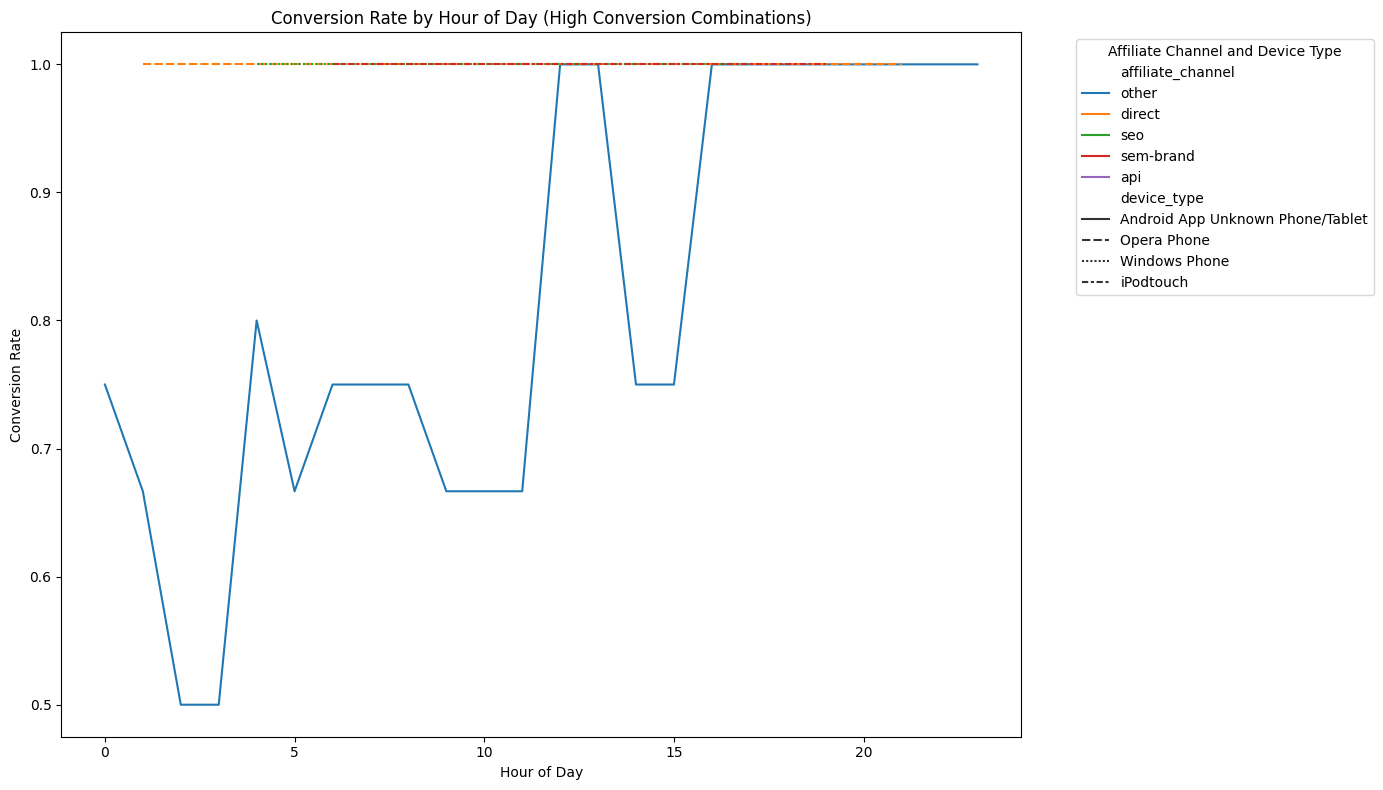

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 사용자 데이터와 세션 데이터 로드
users_df = pd.read_csv('/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/train_users_2.csv')
sessions_df = pd.read_csv('/content/drive/MyDrive/DataA_dev/Airbnb_new_user_booking/sessions.csv')

# 사용자 데이터와 세션 데이터 병합
users_df['booked'] = users_df['date_first_booking'].notnull().astype(int)

# 'id' 열 이름을 'user_id'로 변경
users_df.rename(columns={'id': 'user_id'}, inplace=True)


merged_df = pd.merge(users_df, sessions_df, on='user_id', how='inner')

# 세션 타임스탬프 생성
merged_df['timestamp_first_active'] = pd.to_datetime(merged_df['timestamp_first_active'], format='%Y%m%d%H%M%S')
merged_df['secs_elapsed'] = pd.to_timedelta(merged_df['secs_elapsed'], unit='s')
merged_df['session_timestamp'] = merged_df['timestamp_first_active'] + merged_df['secs_elapsed']

# 시간대별 분석을 위해 시간과 요일 정보 추출
merged_df['hour'] = merged_df['session_timestamp'].dt.hour
merged_df['weekday'] = merged_df['session_timestamp'].dt.weekday

# 상위 전환율 조합 필터링
high_conversion_combinations = [
    ('api', 'Windows Phone'),
    ('direct', 'Opera Phone'),
    ('other', 'Android App Unknown Phone/Tablet'),
    ('sem-brand', 'iPodtouch'),
    ('seo', 'Windows Phone')
]

filtered_data = merged_df[
    merged_df[['affiliate_channel', 'device_type']].apply(tuple, axis=1).isin(high_conversion_combinations)
]

# 시간대별 전환율 계산
hourly_dau = filtered_data.groupby(['hour', 'affiliate_channel', 'device_type', 'booked'])['user_id'].nunique().reset_index()
hourly_dau.columns = ['hour', 'affiliate_channel', 'device_type', 'booked', 'DAU']

# 예약 전환율 계산
hourly_pivot = hourly_dau.pivot_table(index=['hour', 'affiliate_channel', 'device_type'], columns='booked', values='DAU', fill_value=0).reset_index()

# 실제 열 이름을 확인하여 열 이름을 설정
print(hourly_pivot.columns)

# 열 이름 설정
hourly_pivot.columns = ['hour', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']

# 전환율 계산
hourly_pivot['conversion_rate'] = hourly_pivot['DAU_booked'] / (hourly_pivot['DAU_not_booked'] + hourly_pivot['DAU_booked'])

# 전환율이 0이 아닌 경우만 필터링
hourly_pivot = hourly_pivot[hourly_pivot['conversion_rate'] > 0]

# 시간대별 전환율 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=hourly_pivot, x='hour', y='conversion_rate', hue='affiliate_channel', style='device_type')
plt.title('Conversion Rate by Hour of Day (High Conversion Combinations)')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.legend(title='Affiliate Channel and Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Unexpected number of columns: 7


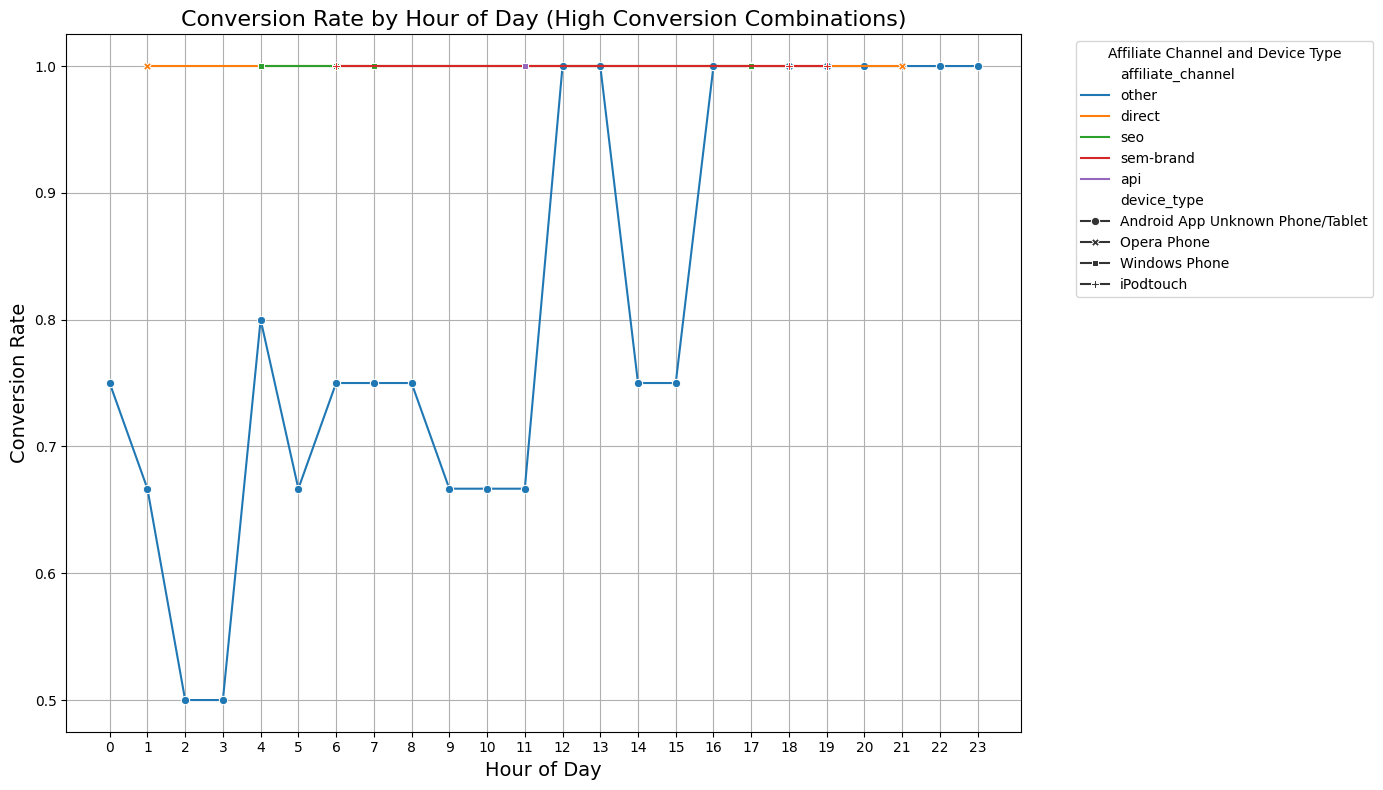

In [ ]:
# 열 이름 설정
if len(hourly_pivot.columns) == 5:
    hourly_pivot.columns = ['hour', 'affiliate_channel', 'device_type', 'DAU_not_booked', 'DAU_booked']
elif len(hourly_pivot.columns) == 4:
    hourly_pivot.columns = ['hour', 'affiliate_channel', 'device_type', 'DAU_booked']
    hourly_pivot['DAU_not_booked'] = 0
else:
    print("Unexpected number of columns:", len(hourly_pivot.columns))

# 전환율 계산
hourly_pivot['conversion_rate'] = hourly_pivot['DAU_booked'] / (hourly_pivot['DAU_not_booked'] + hourly_pivot['DAU_booked'])

# 전환율이 0이 아닌 경우만 필터링
hourly_pivot = hourly_pivot[hourly_pivot['conversion_rate'] > 0]

# 개선된 그래프 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=hourly_pivot, x='hour', y='conversion_rate', hue='affiliate_channel', style='device_type', markers=True, dashes=False)
plt.title('Conversion Rate by Hour of Day (High Conversion Combinations)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.legend(title='Affiliate Channel and Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()